# Tutorial on fitting multiple datasets using MultiFitter
Often we have multiple datasets for a Miyake event. Instead of fitting a model to each dataset indivudually, we can use a MultiFitter object to fit to all the datasets at once! Here's how we can do it,

In [1]:
import numpy as np
import ticktack
import jax.numpy as jnp
from jax import jit
from ticktack import fitting
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

First, we need to make a directory and place our datasets inside it. Each dataset should be a csv file, and has the same format as `example.csv`.


### Example 1: Fit a sinusoid model to the `775CE` Miyake event with `MCMC`.

In [2]:
mf, sampler = fitting.fit_event(year=775, # the year of the event
                                path='775CE', 
                                production_model="simple_sinusoid", 
                                sampler="MCMC", 
                                params=jnp.array([775.1, 0.3, 1.6, 6.5]), 
                                low_bounds=jnp.array([770., 0., 0, 0.]),
                                up_bounds=jnp.array([780., 5., 11, 15.]),
                                burnin=250, production=250)

INFO[2022-03-09 15:28:07,059]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-03-09 15:28:07,060]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-03-09 15:28:07,061]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-03-09 15:28:07,062]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Retrieving data...


100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.88it/s]


Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [05:20<00:00,  1.28s/it]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [05:17<00:00,  1.27s/it]


WARNING[2022-03-09 15:38:55,651]: Parameter start date (yr) in chain Chain 0 is not constrained
WARNING[2022-03-09 15:38:55,751]: Parameter spike production (atoms/cm$^2$ yr/s) in chain Chain 0 is not constrained


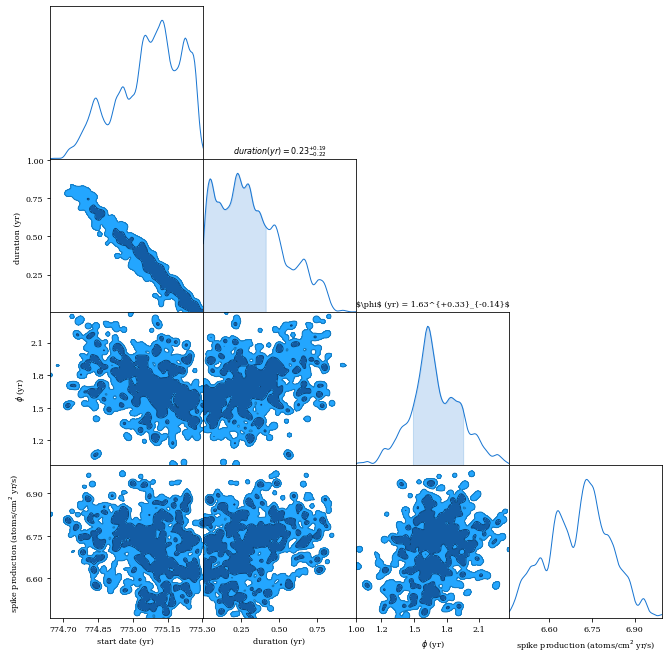

In [3]:
labels = ["start date (yr)", "duration (yr)", "$\phi$ (yr)", "spike production (atoms/cm$^2$ yr/s)"]
mf.chain_summary(sampler, walkers=8, labels=labels) # by default walker = dim(params) * 2

This is a rough estimate of the posterior of these parameters. We can get a much better corner plot if the burn-in steps and the production steps are higher (say 1000).

We can also define a custom parametric production model for fitting a MultiFitter. Here we will use a simple flat production function with a super gaussian spike. The only parameters for this model are: start date of the event, duration of the event, spike production

### Example 2: Fit a custom model to the `775CE` Miyake event with `MCMC`.

In [4]:
@jit
def super_gaussian(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
@jit
def super_gaussian_pulse(t, *args):
    start_time, duration, area = jnp.array(list(args)).reshape(-1)
    height = super_gaussian(t, start_time, duration, area)
    production = 1.88 + height # 1.88 is the steady state production rate for Guttler15 model
    return production

In [5]:
mf, sampler = fitting.fit_event(year=775, 
                                path='775CE', 
                                production_model=super_gaussian_pulse, 
                                sampler="MCMC", 
                                params=jnp.array([775.1, 0.3, 6.5]), 
                                low_bounds=jnp.array([770., 0., 0.]),
                                up_bounds=jnp.array([780., 5., 15.]), 
                               burnin=250, production=250)

Retrieving data...


100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.75it/s]


Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.77it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.79it/s]


WARNING[2022-03-09 15:40:16,154]: Parameter start date (yr) in chain Chain 0 is not constrained
WARNING[2022-03-09 15:40:16,171]: Parameter duration (yr) in chain Chain 0 is not constrained


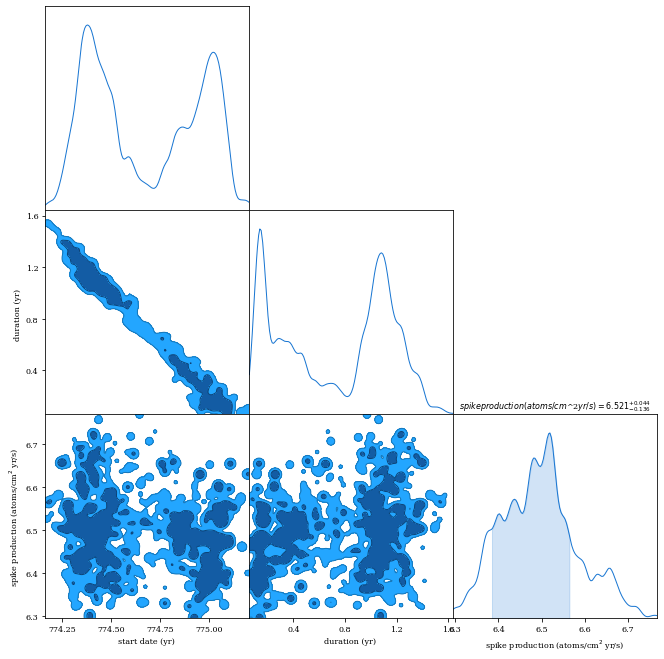

In [6]:
labels = ["start date (yr)", "duration (yr)", "spike production (atoms/cm$^2$ yr/s)"]
mf.chain_summary(sampler, walkers=6, labels=labels)